In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.model_selection import cross_val_score
import numpy as np

import lightgbm as lgb
from imblearn.under_sampling import RandomUnderSampler

/Users/takuro17/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train_df = pd.read_csv("resources/train.csv")
test_df = pd.read_csv("resources/test.csv")
submit = pd.read_csv("resources/sample_submission.csv")

In [3]:
X_train = train_df.iloc[:,2:].values
y_train = train_df.iloc[:,1].values

In [4]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [5]:
# 正例の数を保存
num_train_df_p = len(train_df[train_df['target'] == 1])
num_train_df_n = len(train_df[train_df['target'] == 0])
print(num_train_df_p, num_train_df_n)

rus = RandomUnderSampler(ratio={0: num_train_df_p*2, 1: num_train_df_p}, random_state=70)

# 学習用データに反映
X_train, y_train = rus.fit_sample(train_df.iloc[:,2:].values, train_df.iloc[:,1].values)
print(X_train.shape)

20098 179902
(60294, 200)


In [6]:
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# model = lgb.LGBMClassifier(class_weight='balanced')
# param_dist = {"max_depth": [25,50, 75],
#               "learning_rate" : [0.01,0.05,0.1],
#               "num_leaves": [300,900,1200],
#               "n_estimators": [200]
#              }

# from sklearn.model_selection import GridSearchCV
# grid_search = GridSearchCV(model, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="roc_auc", verbose=5)
# grid_search.fit(X_train, y_train)
# grid_search.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 42.1min


In [7]:
scores = cross_val_score(model, X_train, y_train)
# 各分割におけるスコア
print('Cross-Validation scores: {}'.format(scores))

/Users/takuro17/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Cross-Validation scores: [0.80173143 0.80296547 0.80345325]


In [9]:
predicted = model.predict(test_df.iloc[:,1:])

In [11]:
print(predicted)
print(len(predicted))
print(sum([1 for i in predicted if i == 0]))

[0 0 0 ... 0 0 0]
200000
178600


In [12]:
submit.drop('target', axis=1)
submit['target'] = predicted
submit.to_csv('under_sampling_lightgbm.csv', index = False)

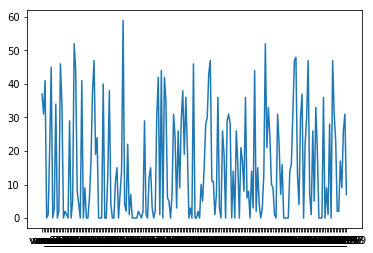

In [42]:
X = np.array(train_df.columns[2:])
y = np.array(model.feature_importances_)

plt.plot(X,y)
plt.show()

In [40]:
for idx, x in enumerate(np.argsort(y)[::-1]):
    print(idx,X[x], y[x])

0 var_53 59
1 var_21 52
2 var_146 52
3 var_166 48
4 var_34 47
5 var_190 47
6 var_110 47
7 var_165 47
8 var_174 47
9 var_99 46
10 var_12 46
11 var_6 45
12 var_22 44
13 var_78 44
14 var_139 44
15 var_109 43
16 var_76 42
17 var_80 42
18 var_26 41
19 var_2 41
20 var_40 40
21 var_44 38
22 var_92 38
23 var_33 38
24 var_170 37
25 var_0 37
26 var_133 36
27 var_184 36
28 var_115 36
29 var_94 36
30 var_81 35
31 var_9 34
32 var_13 34
33 var_148 33
34 var_179 33
35 var_198 31
36 var_122 31
37 var_86 31
38 var_154 31
39 var_191 31
40 var_1 31
41 var_164 31
42 var_108 30
43 var_75 30
44 var_173 30
45 var_169 30
46 var_67 29
47 var_91 29
48 var_18 29
49 var_121 29
50 var_107 28
51 var_188 28
52 var_123 28
53 var_177 26
54 var_127 26
55 var_118 26
56 var_89 26
57 var_197 26
58 var_149 24
59 var_87 24
60 var_36 24
61 var_192 23
62 var_56 22
63 var_172 22
64 var_155 22
65 var_5 21
66 var_95 21
67 var_130 21
68 var_147 21
69 var_180 20
70 var_93 19
71 var_35 19
72 var_119 19
73 var_32 17
74 var_195 17
75